In [2]:
# Importamos las librerías que vamos a utilizar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50

from keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
# Cargamos los datos que vamos a utilizar.
df_train = pd.read_csv(r'..\Data\processed\train-processed.csv')
df_val = pd.read_csv(r'..\Data\processed\val-processed.csv')

images_train = np.load(
    '../Data/processed/image_array100_train.npy', allow_pickle=True)
images_val = np.load(
    '../Data/processed/image_array100_val.npy', allow_pickle=True)


In [4]:
print(images_train.shape)
print(images_val.shape)

(6637, 100, 100, 3)
(6685, 100, 100, 3)


In [5]:
X = images_train
y_gender = df_train['Gender']
y_age_raw = df_train['Age']
# Normalizamos los datos de edad para obtener mejor convergencia
# 80 es el mayor dato de edad según el autor del set de datos.
y_age = y_age_raw / 80 

y_gender = np.array(y_gender)
y_age = np.array(y_age)

print('Dimensiones de X:', X.shape)
print('Dimensiones de y_gender:', y_gender.shape)
print('Dimensiones de y_age:', y_age.shape)

Dimensiones de X: (6637, 100, 100, 3)
Dimensiones de y_gender: (6637,)
Dimensiones de y_age: (6637,)


In [6]:
X_val = images_val
y_gender_val = df_val['Gender']
y_age_raw_val = df_val['Age']
y_age_val = y_age_raw_val / 80

y_gender_val = np.array(y_gender_val)
y_age_val = np.array(y_age_val)

print('Dimensiones de X:', X_val.shape)
print('Dimensiones de y_gender:', y_gender_val.shape)
print('Dimensiones de y_age:', y_age_val.shape)

Dimensiones de X: (6685, 100, 100, 3)
Dimensiones de y_gender: (6685,)
Dimensiones de y_age: (6685,)


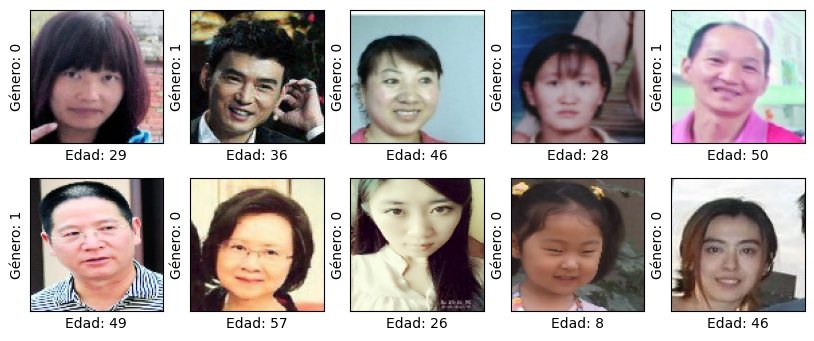

In [7]:
# Verificamos que todo esté correcto:
plt.figure(figsize=(10, 4))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X[i])
    plt.xlabel(f'Edad: {int(80*y_age[i])}')
    plt.ylabel(f'Género: {y_gender[i]}')
plt.show()


In [18]:
# Vamos a utilizar transferlearning, vamos a utilizar el modelo ResNet50 con los pesos previamente
# ajustados con el dataset imagenet, pero sin coger la ultima capa la cual sustituimos por la nuestra.
imagenet = ResNet50(weights='imagenet', include_top=False, input_shape = (100,100,3))

# congelamos las capas del modelo para no modificar los pesos previamente entrenados.
# se podrían no congelar las últimas capas para entrenarlas también, pero en este caso de ejemplo
# no lo vamos a hacer.
for layer in imagenet.layers:
    layer.trinable = False

# Capa de Global Average Pooling, en esta capa aplanamos los datos que han pasado por las 
# capas del modelo.
x = imagenet.output
x = GlobalAveragePooling2D()(x)

# Capa para la clasificación de género:
gender_out = Dense(1, activation = 'sigmoid', name='gender_out')(x)

# Capa para la predicción de edad:
age_out = Dense(1, activation='relu', name='age_out')(x)

# Creamos el modelo añadiendo nuestras capas de salida:
model = tf.keras.Model(inputs=imagenet.input, outputs=[gender_out, age_out])

# Compilamos el modelo:
model.compile(optimizer='adam',
                     loss={'gender_out': 'binary_crossentropy', 'age_out': 'mae'},
                     metrics={'gender_out': 'accuracy', 'age_out': 'mae'})

In [ ]:
ckpt_path = '../models/model3-RGB.h5'
# Crear el callback para guardar los pesos
checkpoint_callback = ModelCheckpoint(
    filepath=ckpt_path,
    save_weights_only=False,
    monitor='val_loss',  # Monitorear la pérdida en el conjunto de validación
    save_best_only=True,  # Guardar solo los pesos del mejor modelo según la métrica monitoreada
    mode='min',  # Modo 'min' para minimizar la pérdida
    verbose=1)  # Imprimir mensajes al guardar los pesos

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenamos al modelo:
history = model.fit(x=X, y={'gender_out': y_gender, 'age_out': y_age}, batch_size=32, 
                    epochs=10, validation_data=(X_val, {'gender_out': y_gender_val, 'age_out': y_age_val}),callbacks=[early_stopping, checkpoint_callback] )

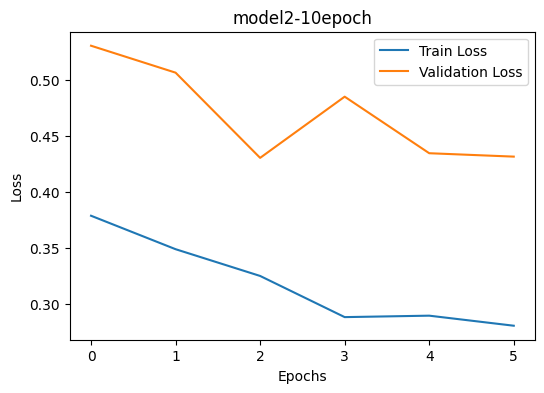

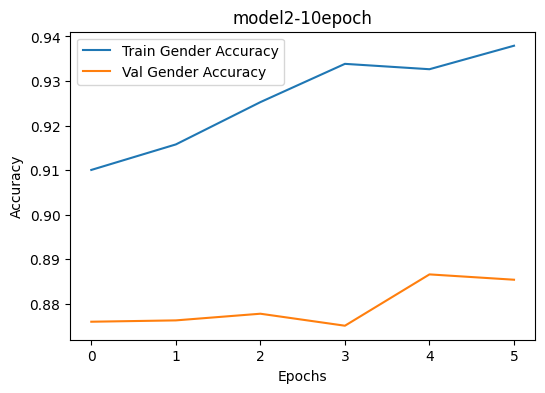

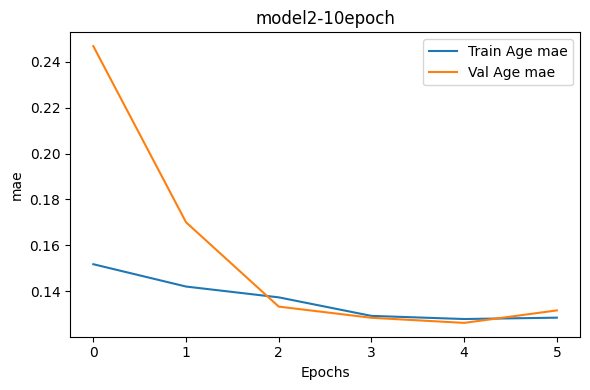

In [52]:
# Obtener las métricas del historial
train_loss = history.history['loss']
train_gender_loss = history.history['gender_out_loss']
train_age_loss = history.history['age_out_loss']
train_gender_accuracy = history.history['gender_out_accuracy']
train_age_mae = history.history['age_out_mae']

val_loss = history.history['val_loss']
val_gender_loss = history.history['val_gender_out_loss']
val_age_loss = history.history['val_age_out_loss']
val_gender_accuracy = history.history['val_gender_out_accuracy']
val_age_mae = history.history['val_age_out_mae']

titulo = 'model2-10epoch'

# Graficar las curvas de pérdida
plt.figure(figsize=(6, 4))
plt.title(titulo)

plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Graficar las curvas de precisión
plt.figure(figsize=(6, 4))
plt.title(titulo)
plt.plot(train_gender_accuracy, label='Train Gender Accuracy')
plt.plot(val_gender_accuracy, label='Val Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Graficar las curvas de error:
plt.figure(figsize=(6, 4))
plt.title(titulo)
plt.plot(train_age_mae, label='Train Age mae')
plt.plot(val_age_mae, label='Val Age mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()

plt.tight_layout()
plt.show()

En este ejemplo hemos hecho poco entrenamiento y no hemos seleccionado correctamente los hiperparámetros, pero con esta técnica se pueden obtener buenos resultados.